Imports

In [1]:
import itertools
import cv2
import os
import time

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB7  as PretrainedModel, preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from glob import glob

Data Preparation

In [2]:
folderPath = ('cancer_images/')

In [3]:
folders = glob(folderPath  + '/*')
images = glob(folderPath + '/*/*.jpeg')
print("Folders:", folders)
print("Images count:", len(images))

Folders: ['cancer_images\\ColonAdenocarcinoma', 'cancer_images\\ColonBenignTissue', 'cancer_images\\LungAdenocarcinoma', 'cancer_images\\LungBenignTissue', 'cancer_images\\LungSquamousCellCarcinoma']
Images count: 25000


In [4]:
classLabels = ["ColonAdenocarcinoma", "ColonBenignTissue", "LungAdenocarcinoma", "LungBenignTissue", "LungSquamousCellCarcinoma"]
imageSize = (224, 224)  

dataset = []  # List to store image paths and labels

for label in classLabels:
    classDirectory = os.path.join(folderPath, label)
    class_images = os.listdir(classDirectory)
    for imageName in class_images:
        imagePath = os.path.join(classDirectory, imageName)
        image = cv2.imread(imagePath)  # load image using OpenCV
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convert BGR to RGB
        image = cv2.resize(image, imageSize)  # resize image
        image = image.astype(np.float32) / 255.0  # normalize pixel values
        dataset.append((image, label))

Sample data presentation

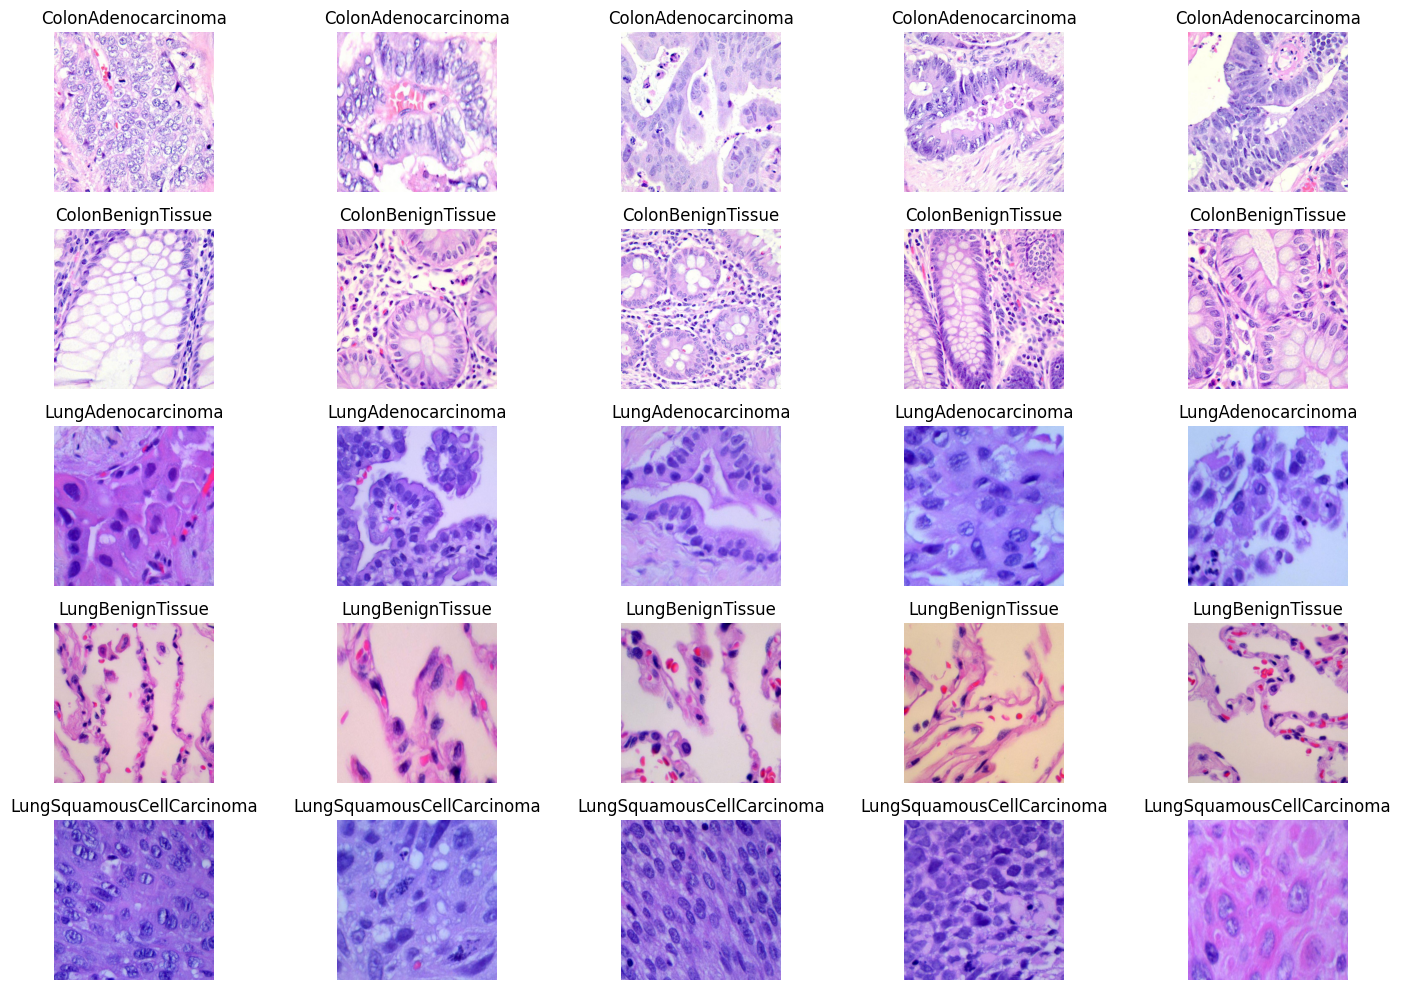

In [14]:
from PIL import Image
num_images_to_display = 5

plt.figure(figsize=(15, 10))

for label in classLabels:
    class_directory = os.path.join(folderPath, label)
    class_images = os.listdir(classDirectory)[:num_images_to_display]

    for i, imageName in enumerate(class_images, 1):
        image_path = os.path.join(classDirectory, imageName)
        image = Image.open(image_path)

        plt.subplot(len(classLabels), num_images_to_display, (classLabels.index(label) * num_images_to_display) + i)
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')

plt.tightLayout()
plt.show()

Data Generation

In [36]:
dataGen = ImageDataGenerator(
    validation_split = 0.2,
    rotation_range=20,          # Rotate images up to 20 degrees
    width_shift_range=0.2,      # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,     # Shift images vertically by up to 20% of their height
    shear_range=0.2,            # Shear transformations
    zoom_range=0.2,             # Zoom in/out by up to 20%
    horizontal_flip=True,       # Flip images horizontally
    vertical_flip=False,        # Don't flip images vertically
    fill_mode='nearest'         # Fill missing pixels with the nearest value
)


image_size = (224, 224)
batchSize = 128
X = Y = 224

trainData = dataGen.flow_from_directory(folderPath,
                                    class_mode = "categorical",
                                    target_size = image_size,
                                    color_mode="rgb",
                                    batch_size = batchSize, 
                                    shuffle = True,
                                    subset='training',
                                    seed = 42)

valData = dataGen.flow_from_directory(folderPath,
                                      class_mode = "categorical",
                                      target_size = image_size,
                                      color_mode="rgb",
                                      batch_size = batchSize, 
                                      shuffle = False,
                                      subset='validation',
                                      seed = 42)

Found 20000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


Model building

In [38]:
ptm = PretrainedModel(
    input_shape=(X, Y, 3),
    weights='imagenet',
    include_top=False)

ptm.trainable = False

K = len(folders)

x = GlobalAveragePooling2D()(ptm.output)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)

y = Dense(K, activation='softmax')(x)

model = Model(inputs=ptm.input, outputs=y)

In [39]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [40]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_2[0][0]'

In [41]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    trainData,
    validation_data=valData,
    epochs=16,
    callbacks=[early_stopping])

Epoch 1/16
157/157 [==============================] - 4968s 32s/step - loss: 0.2211 - accuracy: 0.9247 - val_loss: 0.1068 - val_accuracy: 0.9598
Epoch 2/16
157/157 [==============================] - 4774s 30s/step - loss: 0.1106 - accuracy: 0.9592 - val_loss: 0.0775 - val_accuracy: 0.9710
Epoch 3/16
157/157 [==============================] - 4496s 29s/step - loss: 0.0939 - accuracy: 0.9639 - val_loss: 0.0788 - val_accuracy: 0.9700
Epoch 4/16
157/157 [==============================] - 4570s 29s/step - loss: 0.0858 - accuracy: 0.9672 - val_loss: 0.0638 - val_accuracy: 0.9738
Epoch 5/16
157/157 [==============================] - 5241s 33s/step - loss: 0.0800 - accuracy: 0.9696 - val_loss: 0.0631 - val_accuracy: 0.9742
Epoch 6/16
157/157 [==============================] - 4553s 29s/step - loss: 0.0718 - accuracy: 0.9740 - val_loss: 0.0663 - val_accuracy: 0.9736
Epoch 7/16
157/157 [==============================] - 4291s 27s/step - loss: 0.0705 - accuracy: 0.9730 - val_loss: 0.0723 - val_ac

In [42]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

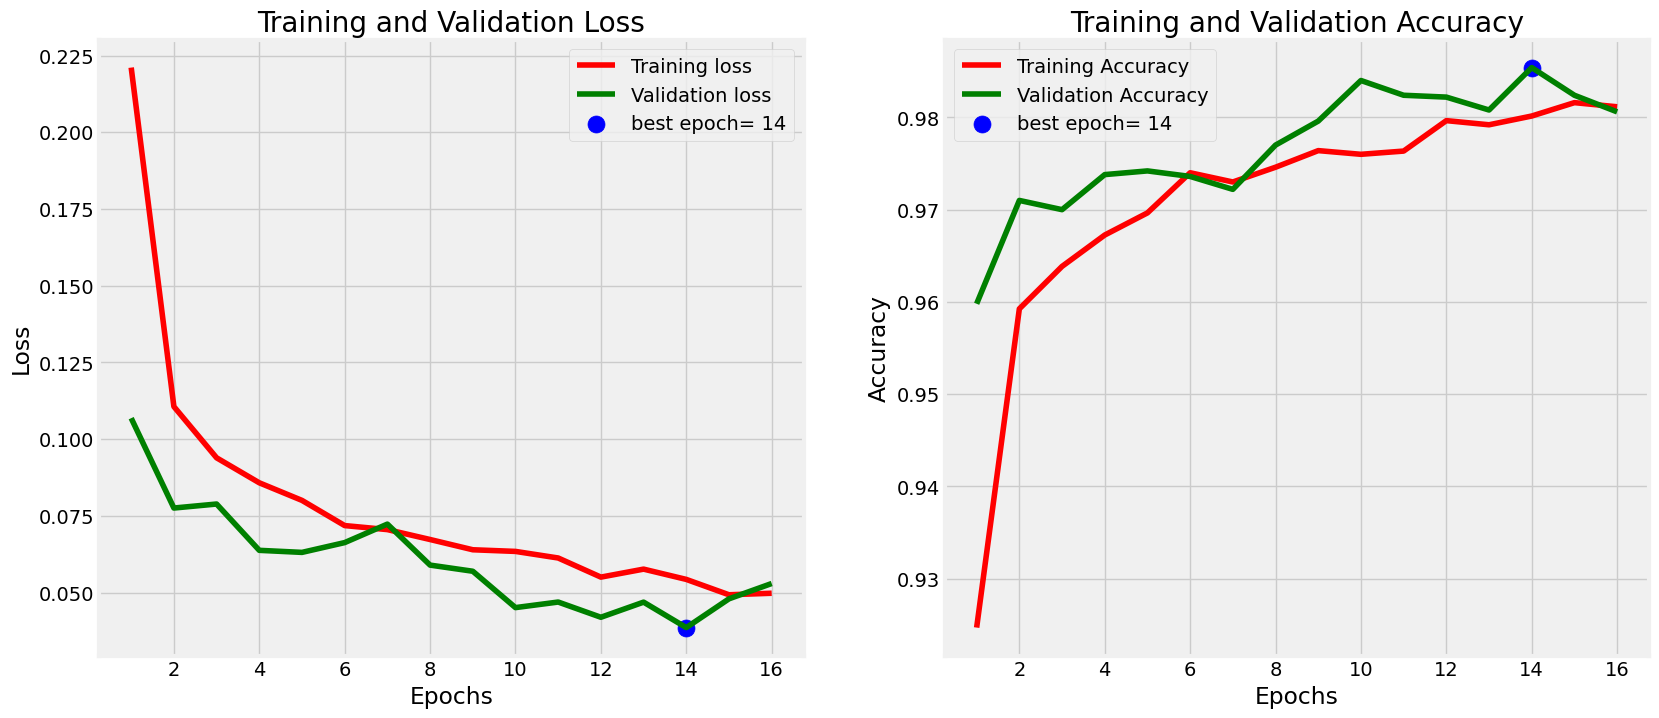

In [43]:
plot_training(history)

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

preds = model.predict_generator(valData)
y_pred = np.argmax(preds, axis=1)
print(y_pred)



C:\Users\natdzi3\AppData\Local\Temp\ipykernel_6548\239202146.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(valData)


[0 0 0 ... 4 4 4]


Genrating classification report and cofusion matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


g_dict = valData.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(valData.classes, y_pred)

# Classification report
print(classification_report(valData.classes, y_pred, target_names= classes))



                           precision    recall  f1-score   support

      ColonAdenocarcinoma       1.00      0.99      1.00      1000
        ColonBenignTissue       1.00      1.00      1.00      1000
       LungAdenocarcinoma       0.94      0.97      0.95      1000
         LungBenignTissue       0.98      1.00      0.99      1000
LungSquamousCellCarcinoma       0.99      0.94      0.96      1000

                 accuracy                           0.98      5000
                macro avg       0.98      0.98      0.98      5000
             weighted avg       0.98      0.98      0.98      5000



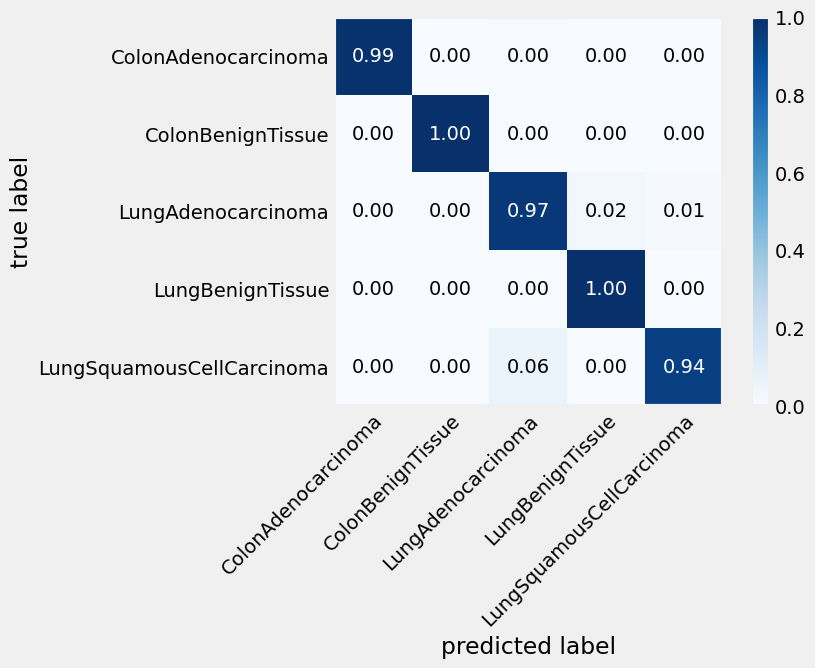

In [68]:
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names = classes)
plt.show()

In [69]:
model.save('model.h5')

C:\Users\natdzi3\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
